In [1]:
# Add the parent directory to the path so that we can import the necessary modules
import sys
sys.path.append('../')

# Hyperparameters

In [2]:
args = {
    'categories': ['chair'],
    'train_epochs': 50,
    'lr': 0.001,
    'load_checkpoint': False, 
    'save_checkpoint': 'all_depth4',
    'save_per_epochs': 50
}

# Dataset for Point-Voxels

In [6]:
from datasets.shapenet_pointflow_sparse import get_dataloaders
from pclab.utils import DataLoaders

path = "/home/tourloid/Desktop/PhD/Data/ShapeNetCore.v2.PC15k"
#path = "/home/vvrbeast/Desktop/Giannis/Data/ShapeNetCore.v2.PC15k"
train_dl, valid_dl = get_dataloaders(path, args['categories'])
dls = DataLoaders(train_dl, valid_dl)

(1, 1, 1)
Total number of data:4612
Min number of points: (train)2048 (test)2048
(1, 1, 1)
Total number of data:662
Min number of points: (train)2048 (test)2048


# Network

In [7]:
#export
from models.modelv1 import SPVUnet

# Training

## Callbacks

In [8]:
#export
from pclab.learner import *
from pclab.utils import def_device
import fastcore.all as fc
from typing import Mapping
from copy import copy
from torcheval.metrics import Mean
from utils.callbacks import GradientClipCB
from functools import partial
import torch 
import torch.nn as nn
import torchsparse

In [9]:
class DDPMCB(Callback):
    
    def before_batch(self, learn): 
        pts = learn.batch['input']
        t = torch.tensor(learn.batch['t'])
        noise = learn.batch['noise']
        inp = (pts, t)
        learn.batch = (inp, noise.F)

In [10]:
def to_device(x, device=def_device):
    if isinstance(x, (torch.Tensor, torchsparse.SparseTensor)): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCBSparse(Callback):
    order = DDPMCB.order + 1
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [11]:
# Callback to monitor the loss

class LossCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = learn.batch
        #for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=2)

## Train

In [12]:
get_model = partial(SPVUnet, voxel_size=0.1, pres=1e-8)

In [13]:
from utils import model_num_params
model = get_model()
model_num_params(model)

15860739

### LR Finder

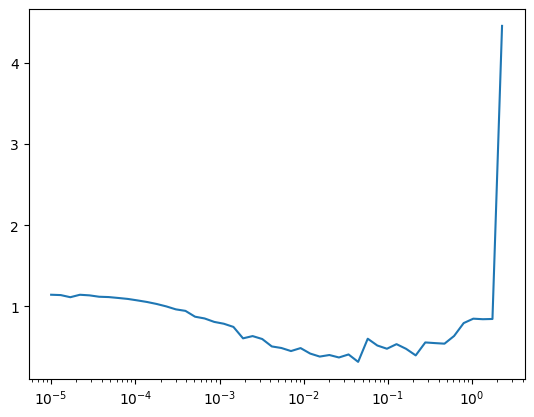

In [10]:
ddpm_cb = DDPMCB()
model = get_model()
learn = TrainLearner(model, dls, nn.MSELoss(), cbs=[ddpm_cb, DeviceCBSparse(), GradientClipCB()], opt_func=torch.optim.Adam)
learn.lr_find(max_mult=3)

## Training loop

In [11]:
lr = 0.005
epochs = 100 #500 #args['train_epochs'] #400

model = get_model()

# scheduler
total_steps = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps = total_steps)

# Callbacks
ddpm_cb = DDPMCB()
cbs = [ddpm_cb, DeviceCBSparse(), ProgressCB(plot=False), LossCB(), BatchSchedCB(sched), GradientClipCB()]

learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(epochs)

loss,epoch,train
0.490,0,train
0.352,0,eval
0.335,1,train
0.311,1,eval
0.324,2,train
0.316,2,eval
0.316,3,train
0.318,3,eval
0.303,4,train
0.320,4,eval


# Inference

In [12]:
from tqdm import tqdm
import math
import numpy as np
from utils.visualization import quick_vis_batch
from torchsparse.utils.quantize import sparse_quantize
from torchsparse import SparseTensor
from torchsparse.utils.collate import sparse_collate_fn
vis_batch = partial(quick_vis_batch, x_offset = 8, y_offset=8)

## Noise Batch Generation

In [13]:
from utils.schedulers import DDIMScheduler

In [14]:
sched = DDIMScheduler(beta_min=0.0001, beta_max=0.01, n_steps=1000, s_steps=100) 

In [15]:
batch = sched.sample(model, 32)

In [17]:
vis_batch(batch)